In [25]:
import os
from datetime import datetime
from sys import getsizeof
import gc

import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers, models, optimizers, regularizers, callbacks, utils
from skimage import color
import sklearn.neighbors as nn

import matplotlib.pyplot as plt

In [26]:
!tar -k -C {notebook_dir} -xf {os.path.join(notebook_dir, tar_file)}

zsh:1: bad pattern: os.path.join(notebook_dir


In [27]:
# Hyperparameters
# Original: 250, 250
IMG_HEIGHT = 128
IMG_WIDTH = 128

TRAINING_SIZE = 200
VALIDATION_SIZE = np.int(TRAINING_SIZE * 0.2)
TEST_SIZE = 10
VALIDATION_END = TRAINING_SIZE + VALIDATION_SIZE

EPOCHS=2000
PATIENCE=500

LEARNING_RATE = 0.00001
BATCH_SIZE=5
OUTPUT_DIM=1

/var/folders/kc/txgh3xkn0xgfsxb3fpxhwsvc0000gn/T/ipykernel_1887/3874301745.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  VALIDATION_SIZE = np.int(TRAINING_SIZE * 0.2)


13233


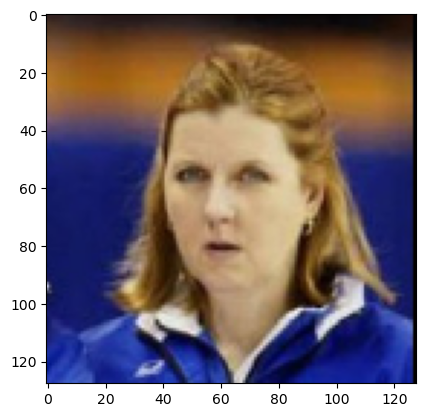

In [28]:
def get_image_paths(limit):
    count = 0
    paths = []
    # Çalıştığınız not defterinin bulunduğu dizini alın
    notebook_dir = os.getcwd()
    for dirpath, dirnames, filenames in os.walk(os.path.join(notebook_dir, 'lfw_funneled')):
        if dirpath == os.path.join(notebook_dir, 'lfw_funneled'):
            continue

        for filename in filenames:
            path = os.path.join(dirpath, filename)
            paths.append(path)
            count += 1
            if count >= limit:
                return paths
    return paths

def load_data_sequence(paths, start, end):
    data = []
    for i in range(start, end):
        data.append(load_data(paths[i]))
    return np.array(data)

def load_data(path):
    image = load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    lab = img_to_lab(image)
    image.close()
    return lab

def img_to_lab(image):
    return color.rgb2lab(1.0/255 * img_to_array(image))

def shuffle(array):
    return tf.random.shuffle(array)

# Get path of all images
paths = get_image_paths(20000)
print(len(paths))
example_index = 5
example_data = load_data_sequence(paths, example_index, example_index+1)
gc.collect()

plt.imshow(color.lab2rgb(example_data[0]))
plt.show()

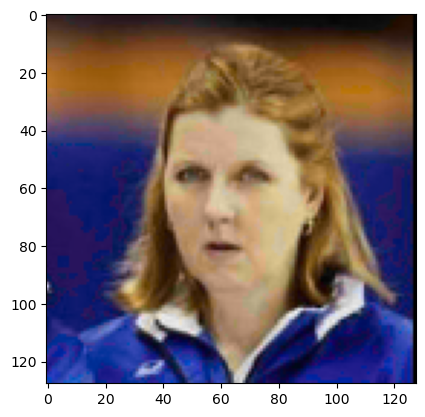

In [29]:
# Load 313 ab points of color hull
pts_in_hull = np.load('archive/pts_in_hull.npy')
# Create nearest neighbour model to map colors
color_picker = nn.NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(pts_in_hull)

# HxW images of 313 dimensions one-hot encoded for color bins
def mapColorToHullPts(ab_true):
    ab_indices = np.zeros((IMG_HEIGHT, IMG_WIDTH, OUTPUT_DIM))
    for i in range(0, IMG_HEIGHT):
        for j in range(0, IMG_WIDTH):
            _, index = color_picker.kneighbors([ab_true[i, j, :]])
            ab_indices[i, j] = index[0][0]
    return ab_indices.astype(int);

def mapHullPtsToColor(indices):
    ab_mapped = np.zeros((IMG_HEIGHT, IMG_WIDTH, 2))
    for i in range(0, IMG_HEIGHT):
        for j in range(0, IMG_WIDTH):
            index = indices[i, j]
            ab_mapped[i, j, :] = pts_in_hull[index]
    #del indices
    return ab_mapped

test_canvas = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
test_canvas[:,:,0] = example_data[0, :, :, 0]
test_indices = mapColorToHullPts(example_data[0, :, :, 1:])
test_canvas[:,:,1:] = mapHullPtsToColor(test_indices)
plt.imshow(color.lab2rgb(test_canvas))

In [30]:
def create_model():
    l2reg = regularizers.l2(0.0001)
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), kernel_regularizer=l2reg))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2, kernel_regularizer=l2reg))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2, kernel_regularizer=l2reg))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling2D((2,2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2reg))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2reg))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling2D((2,2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2reg))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2reg))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(313, (1, 1), activation='softmax', padding='same'))
    return model

model = create_model();
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 256)       0         
                                                                 
 batch_normalization (Batch  (None, 32, 32, 256)       1

In [31]:
checkpoint = callbacks.ModelCheckpoint("checkpoint", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early_stopping = callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=PATIENCE)

In [32]:
def prepareTrainingData():
    SIZE = TRAINING_SIZE + VALIDATION_SIZE
    data = load_data_sequence(paths, 0, SIZE)
    X = data[:,:,:,0]
    X = X.reshape(SIZE, IMG_HEIGHT, IMG_WIDTH, 1)
    Y = data[:,:,:,1:]
    Y = np.array([mapColorToHullPts(y) for y in Y])
    Y = Y.reshape(SIZE, IMG_HEIGHT, IMG_WIDTH, 1)
    return X, Y

def train_fit():
    X, Y = prepareTrainingData()
    history = model.fit(X, Y, validation_split=0.2, epochs = EPOCHS, verbose=2, callbacks=[early_stopping, checkpoint])
    return history
history = train_fit();
# Load checkpoint weights
model.load_weights("checkpoint")

Epoch 1/2000


In [ ]:
# Plot training & validation loss values
def plot_training():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plot_training()

In [ ]:
test_indices = [10006,10010,10024,10039,10043,10046,10053,10062,10076,10083]
test_data = []
for i in test_indices:
    test_data.append(load_data(paths[i]))
test_data = np.array(test_data)

P = test_data[:,:,:,0]
P = P.reshape(TEST_SIZE, IMG_HEIGHT, IMG_WIDTH, 1)

def reconstructImage(l, ab):
    canvas = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
    canvas[:,:,0] = l
    canvas[:,:,1:] = ab
    return color.lab2rgb(canvas)

def probabilityToIndices(prediction):
    hullPts = np.zeros((IMG_HEIGHT, IMG_WIDTH, OUTPUT_DIM))
    for i in range(0, IMG_HEIGHT):
        for j in range(0, IMG_WIDTH):
            hullPts[i, j] = np.argmax(prediction[i, j, :])
    return hullPts.astype(int)

prediction = model.predict(P)
f, axarr = plt.subplots(TEST_SIZE,3, figsize=(40, 40))
for i in range(TEST_SIZE):
    axarr[i,0].imshow(array_to_img(P[i]), cmap="gray")
    hullPts = probabilityToIndices(prediction[i])
    ab = mapHullPtsToColor(hullPts)
    axarr[i,1].imshow(array_to_img(reconstructImage(P[i,:,:,0], ab)))
    axarr[i,2].imshow(color.lab2rgb(test_data[i]))

In [ ]:
# View prediction on example training item
P0 = example_data[0,:,:,0]
P0 = P0.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)

prediction = model.predict(P0)
f, axarr = plt.subplots(1,3, figsize=(20, 20))
axarr[0].imshow(array_to_img(P0[0]), cmap="gray")
print(np.argmax(prediction[0, 0, 0, :]))
hullPts = probabilityToIndices(prediction[0])
ab = mapHullPtsToColor(hullPts)
print(np.amax(hullPts))
print(np.amin(hullPts))
axarr[1].imshow(array_to_img(reconstructImage(P0[0,:,:,0], ab)))
axarr[2].imshow(color.lab2rgb(example_data[0]))

In [ ]:
def getTimestampString():
    return datetime.now().strftime("%y-%m-%d")

def save_model():
    date = getTimestampString()
    # Save model as JSON
    model_json = model.to_json()
    with open("model"+date+".json", "w") as json_file:
        json_file.write(model_json)
    # Save model weights to HDF5
    model.save_weights("model"+date+".h5")
    print("Saved model to output")
save_model()

In [ ]:
def load_model(model_file, weight_file):
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = models.model_from_json(loaded_model_json)
    # Load weights
    loaded_model.load_weights(weight_file)
    return loaded_model
#date = getTimestampString()
#loaded_model = load_model("model"+date+".json", "model"+date+".h5")

#### Resources
* https://www.tensorflow.org/tutorials/images/cnn
* https://keras.io/getting-started/sequential-model-guide/
* https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/
* https://medium.com/@mahmoudeljiddawi/auto-colorization-of-black-and-white-images-using-machine-learning-auto-encoders-technique-a213b47f7339
* https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148
* https://towardsdatascience.com/colorizing-images-with-a-convolutional-neural-network-3692d71956e2
* https://www.kaggle.com/bmarcos/image-recognition-gender-detection-inceptionv3#Step-1:-Data-Exploration
* https://richzhang.github.io/colorization/
* https://arxiv.org/pdf/1801.09083.pdf
* https://towardsdatascience.com/5-techniques-to-prevent-overfitting-in-neural-networks-e05e64f9f07
* https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
* https://www.kaggle.com/theyoke/predict-famous-people-gender